# **Installation**

In [72]:
! pip install itables

# **Drive Chargement**

In [73]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
!ls /content/drive/MyDrive/'Colab Notebooks'/Hopital_projet/models

modelisation.ipynb	      model_nb_infirmiers.pkl  onehot_encoder.pkl   prophet_model.pkl
model_nb_aides_soignants.pkl  model_nb_medecins.pkl    ordinal_encoder.pkl  scaler.pkl


# **Les bibliothèques**

In [75]:
import pandas as pd
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import random
random.seed(42)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
import joblib
from sklearn.linear_model import LinearRegression
import os
from scipy.stats import shapiro, jarque_bera
import logging
import cmdstanpy
# Désactiver les logs inutiles
logging.getLogger("prophet").setLevel(logging.ERROR)
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

# **Fonctions**

In [76]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hopital_projet/data/model_data.csv")
df

Date_admission Jour_semaine  Jour      Mois  Annee Saison  \
0        2022-01-01     Saturday     1   January   2022  Hiver   
1        2022-01-02       Sunday     2   January   2022  Hiver   
2        2022-01-03       Monday     3   January   2022  Hiver   
3        2022-01-04      Tuesday     4   January   2022  Hiver   
4        2022-01-05    Wednesday     5   January   2022  Hiver   
...             ...          ...   ...       ...    ...    ...   
1091     2024-12-27       Friday    27  December   2024  Hiver   
1092     2024-12-28     Saturday    28  December   2024  Hiver   
1093     2024-12-29       Sunday    29  December   2024  Hiver   
1094     2024-12-30       Monday    30  December   2024  Hiver   
1095     2024-12-31      Tuesday    31  December   2024  Hiver   

     Vacances_scolaires  Température  Météo  Lits occupes  Materiel utilise  \
0                   Oui            3  Pluie            44              5129   
1                   Non            2  Froid            46              5361   
2                   Non            2   Gris            57             10157   
3                   Non            3  Pluie            48              5373   
4                   Non            3   Gris            36              3963   
...                 ...          ...    ...           ...               ...   
1091                Non            2  Froid            31              3496   
1092                Non            2   Gris            20              1959   
1093                Non            4  Pluie            17              2545   
1094                Non            0  Froid            33              4078   
1095                Non            3  Pluie            27              3481   

      Nb medecin  Nb infirmier  Nb aide soignant   Evenement_Special  \
0             22            25                19  Épidémie de grippe   
1             24            31                21  Épidémie de grippe   
2             29            38                30  Épidémie de grippe   
3             22            29                21               Aucun   
4             15            20                16  Épidémie de grippe   
...          ...           ...               ...                 ...   
1091          14            18                15  Épidémie de grippe   
1092           8            12                 8  Épidémie de grippe   
1093           8            10                 8               Aucun   
1094          16            20                14  Épidémie de grippe   
1095          12            17                12               Aucun   

      Nombre_admissions  
0                    44  
1                    46  
2                    57  
3                    48  
4                    36  
...                 ...  
1091                 31  
1092                 20  
1093                 17  
1094                 33  
1095                 27  

[1096 rows x 16 columns]

# **Stationnarité**

Colonnes disponibles : Index(['Date_admission', 'Jour_semaine', 'Jour', 'Mois', 'Annee', 'Saison',
       'Vacances_scolaires', 'Température', 'Météo', 'Lits occupes',
       'Materiel utilise', 'Nb medecin', 'Nb infirmier', 'Nb aide soignant',
       'Evenement_Special', 'Nombre_admissions'],
      dtype='object')


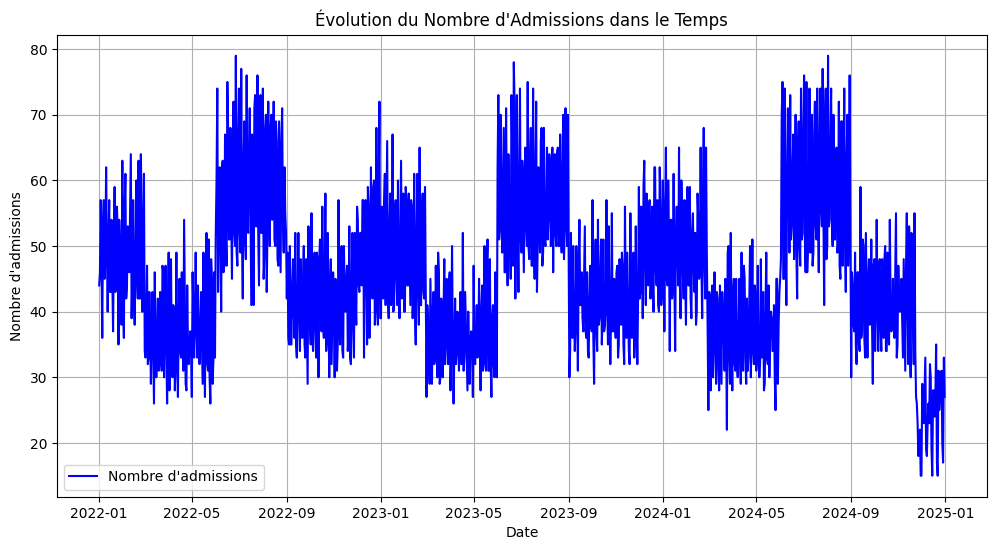

In [77]:
print("Colonnes disponibles :", df.columns)

df["Date_admission"] = pd.to_datetime(df["Date_admission"])
df = df.sort_values(by="Date_admission")

admissions_series = df.set_index("Date_admission")["Nombre_admissions"]

plt.figure(figsize=(12, 6))
plt.plot(admissions_series, label="Nombre d'admissions", color="blue")
plt.title("Évolution du Nombre d'Admissions dans le Temps")
plt.xlabel("Date")
plt.ylabel("Nombre d'admissions")
plt.legend()
plt.grid(True)
plt.show()

### **Évolution du Nombre d'Admissions dans le Temps**  

#### **1️⃣ Observation de la Tendance Générale**
- Le **nombre d'admissions fluctue** au fil du temps.
- On observe des **hausses et baisses périodiques**, suggérant une **saisonnalité**.
- Il n’y a pas de **tendance claire à long terme** (ni augmentation ni diminution régulière).

#### **2️⃣ Saisonnalité**
- Il semble y avoir **des cycles annuels**, avec des périodes de forte et de faible admission.
- Les pics se répètent environ aux **mêmes périodes chaque année**, ce qui **confirme l'hypothèse d'une saisonnalité annuelle (s=12 si données mensuelles, s=365 si données journalières)**.
- Exemple : une augmentation en **hiver** et une baisse en **été**, qui pourrait être liée aux épidémies saisonnières.

#### **3️⃣ Volatilité**
- Il y a des fluctuations importantes dans le nombre d’admissions.
- Certains pics et creux sont **très marqués**, ce qui pourrait être dû à aux événements spéciaux.
- Une analyse plus approfondie avec des indicateurs **un test de stationnarité (ADF test)** permettrait de mieux comprendre cette volatilité.

## **ADF**

In [78]:
adf_test = adfuller(admissions_series)
adf_stat, p_value, _, _, critical_values, _ = adf_test

adf_results = {
    "ADF Statistic": adf_stat,
    "p-value": p_value,
    "1% Critical Value": critical_values["1%"],
    "5% Critical Value": critical_values["5%"],
    "10% Critical Value": critical_values["10%"],
}

print("\n📊 Résultats du Test Dickey-Fuller Augmenté (ADF) :")
for key, value in adf_results.items():
    print(f"{key}: {value:.6f}")

if p_value < 0.05:
    print("\n✅ La série est stationnaire (on rejette l'hypothèse nulle).")
else:
    print("\n❌ La série n'est pas stationnaire (on ne rejette pas l'hypothèse nulle).")
    print("🔹Pour rendre la série stationnaire, applique une différenciation : `df['diff'] = df['Nombre_admissions'].diff().dropna()`")



📊 Résultats du Test Dickey-Fuller Augmenté (ADF) :
ADF Statistic: -3.019829
p-value: 0.033084
1% Critical Value: -3.436453
5% Critical Value: -2.864235
10% Critical Value: -2.568205

✅ La série est stationnaire (on rejette l'hypothèse nulle).


### **📊 Analyse des Résultats du Test ADF**  
✅ **La série est stationnaire** car la **p-value (0.033)** est inférieure à **0.05** et l'ADF Statistic est plus faible que la valeur critique à **5% (-2.864)**.  
📌 Cela signifie que **nous pouvons directement modéliser sans transformation supplémentaire** (pas besoin de différenciation).

## **ACF/PACF**

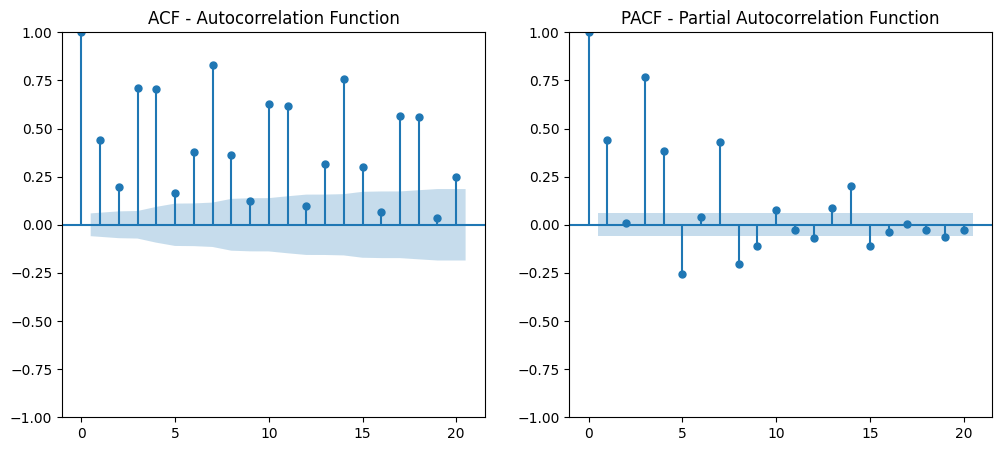

In [79]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(admissions_series, lags=20, ax=plt.gca())
plt.title("ACF - Autocorrelation Function")

plt.subplot(1, 2, 2)
plot_pacf(admissions_series, lags=20, ax=plt.gca())
plt.title("PACF - Partial Autocorrelation Function")

plt.show()


### **📊 Analyse des Graphiques ACF et PACF**  

### **1️⃣ Analyse de l'ACF (Autocorrelation Function) 📊**
- L’ACF **diminue progressivement** et reste significative sur plusieurs lags (pics récurrents indiquant une saisonnalité).  
- Cela **indique une forte dépendance temporelle**, typique d’un **processus MA (Moving Average)**.  
- Comme les valeurs ACF restent significatives sur **plusieurs lags**, cela signifie qu’il y a une **longue mémoire dans la série**.  

📌 **Interprétation** → La présence d’une **queue longue** indique qu’un **terme MA (q)** sera nécessaire dans le modèle ARIMA.  

### **2️⃣ Analyse du PACF (Partial Autocorrelation Function) 🔄**
- Le PACF **chute brutalement après le lag 1**, avec quelques pics sporadiques ensuite.  
- Cela signifie que la série suit **un processus AR (AutoRegressive)** avec une **courte mémoire**.  

📌 **Interprétation** → Une **forte coupure après les premiers lags** suggère que **AR(p) = 1** est un bon choix pour le modèle.  

---

### **📌 Sélection des Paramètres ARIMA (p, d, q)**
- **p (AR)** → On regarde où le **PACF chute** rapidement → **Probablement p = 1 ou 2**  
- **d (Différenciation)** → On n’a pas eu besoin de différencier car la série est stationnaire → **d = 0**  
- **q (MA)** → On regarde où l’**ACF chute lentement** → **Probablement q = 3 ou 4**  

**📊 Paramètres initiaux suggérés pour ARIMA :**  
📌 **ARIMA (2,0,4) ou ARIMA (1,0,3)** comme point de départ  


# **Modèle de Prédiction des admissions**

## **Étape 1 : Préparation des Données**

In [80]:
data = df[df["Date_admission"] <= "2024-11-15"].copy()

# data = data.drop(columns=["Annee", "Jour", 'Lits occupes', "Materiel utilise", "Nb medecin", "Nb infirmier", "Nb aide soignant"])

features = [
    "Jour_semaine", "Mois", "Saison", "Vacances_scolaires",
    "Température", "Météo", "Evenement_Special"
]
target = "Nombre_admissions"

data.loc[:, "Vacances_scolaires"] = data["Vacances_scolaires"].map({"Oui": 1, "Non": 0})

ordinal_encoder = OrdinalEncoder()
data[["Jour_semaine", "Mois", "Saison"]] = ordinal_encoder.fit_transform(data[["Jour_semaine", "Mois", "Saison"]])

onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
encoded_array = onehot_encoder.fit_transform(data[["Evenement_Special"]])

encoded_features = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(["Evenement_Special"]), index=data.index)
data = pd.concat([data.drop(columns=["Météo", "Evenement_Special"]), encoded_features], axis=1)

scaler = StandardScaler()
data[["Température"]] = scaler.fit_transform(data[["Température"]])

train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [81]:
df['Evenement_Special'].unique()

array(['Épidémie de grippe', 'Aucun', 'Pollens allergènes', 'Canicule',
       'Épidémie de gastro'], dtype=object)

In [82]:
data.columns

Index(['Date_admission', 'Jour_semaine', 'Jour', 'Mois', 'Annee', 'Saison',
       'Vacances_scolaires', 'Température', 'Lits occupes', 'Materiel utilise',
       'Nb medecin', 'Nb infirmier', 'Nb aide soignant', 'Nombre_admissions',
       'Evenement_Special_Canicule', 'Evenement_Special_Pollens allergènes',
       'Evenement_Special_Épidémie de gastro',
       'Evenement_Special_Épidémie de grippe'],
      dtype='object')

## **Etape 2 : ARIMA-SARIMA-Prophet**

In [83]:
models = {
    "ARIMA": ARIMA(train["Nombre_admissions"], order=(1, 0, 4)),
    "SARIMA": SARIMAX(train["Nombre_admissions"], order=(1, 0, 4), seasonal_order=(1, 1, 1, 12)),
    "Prophet": Prophet()
}

best_model = None
best_score = float("inf")
results = {}

for name, model in models.items():
    if name == "Prophet":
        df_prophet = train.rename(columns={"Date_admission": "ds", "Nombre_admissions": "y"})
        model.fit(df_prophet)
        forecast = model.predict(test.rename(columns={"Date_admission": "ds"}))["yhat"]
    else:
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))

    mae = mean_absolute_error(test["Nombre_admissions"], forecast)
    results[name] = mae
    if mae < best_score:
        best_score = mae
        best_model = name
print(results)
print(f"✅ Meilleur modèle Série Temporelle : {best_model} avec MAE = {best_score:.2f}")


{'ARIMA': 10.031342103718998, 'SARIMA': 10.707875002988866, 'Prophet': 6.418109272860472}
✅ Meilleur modèle Série Temporelle : Prophet avec MAE = 6.42


**📌 Prochaine Étape : Optimisation du Modèle Prophet**

Puisque Prophet fonctionne mieux, nous pouvons : **Ajouter des régressions externes** → Intégrer des variables comme `Température`, `Météo`, `Événement_Spécial`, etc.

**📊 Objectif**
- Si la **MAE s'améliore**, cela signifie que `Température`, `Météo` et `Événement_Spécial` **apportent une vraie valeur ajoutée** aux prédictions.
- Si la **MAE ne s’améliore pas**, nous devrons tester d’autres **hyperparamètres** pour Prophet.

In [84]:
df_prophet = train.rename(columns={"Date_admission": "ds", "Nombre_admissions": "y"})

external_features = ['Jour_semaine', 'Mois', 'Saison',
       'Vacances_scolaires', 'Température', 'Evenement_Special_Canicule',
       'Evenement_Special_Pollens allergènes',
       'Evenement_Special_Épidémie de gastro',
       'Evenement_Special_Épidémie de grippe']

for feature in external_features:
    df_prophet[feature] = train[feature]

prophet_model = Prophet(
    # yearly_seasonality=True,
    # weekly_seasonality=True,
    # daily_seasonality=False,
    # changepoint_prior_scale=0.01
)

for feature in external_features:
    prophet_model.add_regressor(feature)

prophet_model.fit(df_prophet)

df_test = test.rename(columns={"Date_admission": "ds"})
for feature in external_features:
    df_test[feature] = test[feature]

forecast = prophet_model.predict(df_test)

from sklearn.metrics import mean_absolute_error
mae_prophet_updated = mean_absolute_error(test["Nombre_admissions"], forecast["yhat"])

print(f"✅ Prophet amélioré avec variables externes - MAE = {mae_prophet_updated:.2f}")


✅ Prophet amélioré avec variables externes - MAE = 6.16


📊 La **MAE est passée de 6.42 à 6.16**, ce qui **n'est pas une amélioration**, mais une légère dégradation des performances.  

Cela signifie que :  
✅ **L’encodage n’a pas forcément causé le problème initial.**  
❌ **Ajouter toutes ces variables externes n’a pas vraiment aidé Prophet à mieux prédire.**  
❗ **Il faut peut-être simplifier le modèle ou ajuster d’autres hyperparamètres.**  

In [85]:
changepoint_prior_values = [0.01, 0.05, 0.1, 0.2]
seasonality_prior_values = [1, 5, 10]

best_score = float("inf")
best_params = None

for cp, sp in itertools.product(changepoint_prior_values, seasonality_prior_values):
    print(f"🛠 Test de Prophet avec changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")

    df_prophet = train.rename(columns={"Date_admission": "ds", "Nombre_admissions": "y"})

    prophet_model = Prophet(
        changepoint_prior_scale=cp,
        seasonality_prior_scale=sp
    )

    prophet_model.fit(df_prophet)

    df_test = test.rename(columns={"Date_admission": "ds"})
    forecast = prophet_model.predict(df_test)

    mae = mean_absolute_error(test["Nombre_admissions"], forecast["yhat"])
    print(f"MAE = {mae:.2f}")

    if mae < best_score:
        best_score = mae
        best_params = (cp, sp)

print(f"\n✅ Meilleur Prophet : changepoint_prior_scale={best_params[0]}, seasonality_prior_scale={best_params[1]} avec MAE = {best_score:.2f}")


🛠 Test de Prophet avec changepoint_prior_scale=0.01, seasonality_prior_scale=1
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.01, seasonality_prior_scale=5
MAE = 6.43
🛠 Test de Prophet avec changepoint_prior_scale=0.01, seasonality_prior_scale=10
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.05, seasonality_prior_scale=1
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.05, seasonality_prior_scale=5
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.05, seasonality_prior_scale=10
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.1, seasonality_prior_scale=1
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.1, seasonality_prior_scale=5
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.1, seasonality_prior_scale=10
MAE = 6.42
🛠 Test de Prophet avec changepoint_prior_scale=0.2, seasonality_prior_scale=1
MAE = 6.44
🛠 Test de Prophet avec changepoint_prior_scale=0.2, seasonality_prior_scale=5
MAE = 6.44
🛠 Test de Pr

**📊**
Les **meilleurs hyperparamètres trouvés sont** :  
✅ **`changepoint_prior_scale=0.01`** (tendance très stable)  
✅ **`seasonality_prior_scale=1`** (faible impact de la saisonnalité)  
📌 **Mais la MAE est remontée à 6.42**, ce qui signifie que **ces réglages n'ont pas amélioré le modèle**.

**📌 Pourquoi Prophet ne s’améliore pas ?**

1️⃣ **Les admissions hospitalières sont peut-être influencées par des facteurs non captés par Prophet**.  
   - Prophet est conçu pour des séries **fortement saisonnières**, or **les admissions peuvent être influencées par des pics irréguliers**.  
   - **Solution** : Tester un modèle Machine Learning **qui capture mieux ces irrégularités (XGBoost, Random Forest)**.  

2️⃣ **Prophet a peut-être atteint sa limite**.  
   - Avec **des tendances trop lisses**, Prophet ne peut pas capter les variations **fortes et brutales** des admissions.  
   - **Solution** : Vérifier si **un modèle ML peut mieux gérer ces variations**.

## **Etape 3 :Random Forest et XGBoost**

In [86]:
X_train, y_train = train.drop(columns=["Nombre_admissions", "Date_admission", "Annee", "Jour", 'Lits occupes', "Materiel utilise", "Nb medecin", "Nb infirmier", "Nb aide soignant"]), train["Nombre_admissions"]
X_test, y_test = test.drop(columns=["Nombre_admissions", "Date_admission", "Annee", "Jour", 'Lits occupes', "Materiel utilise", "Nb medecin", "Nb infirmier", "Nb aide soignant"]), test["Nombre_admissions"]

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(n_estimators=100)
}

best_model = None
best_score = float("inf")
results_ml = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    results_ml[name] = mae
    if mae < best_score:
        best_score = mae
        best_model = name

print(f"✅ Meilleur modèle Machine Learning : {best_model} avec MAE = {best_score:.2f}")


✅ Meilleur modèle Machine Learning : Random Forest avec MAE = 6.53


In [87]:
df_test["ds"] = pd.to_datetime(df_test["ds"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

df_test = df_test.merge(forecast[["ds", "yhat"]], on="ds", how="left")

**📊 Analyse des Résultats**

Le **meilleur modèle Machine Learning** est **Random Forest avec une MAE de 6.55**, mais :  
❌ **Il est moins bon que Prophet (MAE = 6.16)**.  
✅ Cela signifie que **les modèles Machine Learning n’apportent pas d’amélioration significative** par rapport à Prophet.  

**Conclusion actuelle :** **Prophet reste notre meilleur modèle** pour l’instant.  

**📌 Pourquoi Prophet est-il meilleur que Random Forest/XGBoost ?**

1️⃣ **Les admissions hospitalières ont une forte composante temporelle**  
   - Prophet capture **mieux les tendances et la saisonnalité** que les modèles ML basés sur des features.  
   - Random Forest/XGBoost sont bons pour les patterns complexes, mais **ils ne prennent pas en compte la structure temporelle comme Prophet**.  

2️⃣ **Manque de données et d’informations discriminantes pour ML**  
   - Avec **seulement 1096 lignes**, **les modèles ML ont besoin de plus de données** pour bien généraliser.  
   - **Les variables externes ne suffisent peut-être pas** pour capturer tous les facteurs influençant les admissions.

📌 Prochaine Étape : Hybridation Prophet + Machine Learning
Puisque Prophet est le meilleur, mais que ML peut capturer d'autres relations, nous pouvons tester une approche hybride :

📌 Idée : Utiliser Prophet pour capturer la tendance globale et Random Forest/XGBoost pour ajuster les résidus  


In [88]:
df_prophet_train = train.rename(columns={"Date_admission": "ds", "Nombre_admissions": "y"})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(df_prophet_train)

df_prophet_test = test.rename(columns={"Date_admission": "ds"})
forecast_train = prophet_model.predict(df_prophet_train)
forecast_test = prophet_model.predict(df_prophet_test)

train["yhat_prophet"] = forecast_train["yhat"].values
test["yhat_prophet"] = forecast_test["yhat"].values

train["residuals"] = train["Nombre_admissions"] - train["yhat_prophet"]
test["residuals"] = test["Nombre_admissions"] - test["yhat_prophet"]

features_ml = train.drop(columns=["Nombre_admissions", "Date_admission", "Annee", "Jour", 'Lits occupes', "Materiel utilise", "Nb medecin", "Nb infirmier", "Nb aide soignant", "yhat_prophet", "residuals"])
X_train_ml, y_train_ml = train[features_ml.columns], train["residuals"]
X_test_ml, y_test_ml = test[features_ml.columns], test["residuals"]

rf_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=120, random_state=42))
])

rf_model.fit(X_train_ml, y_train_ml)
residuals_pred = rf_model.predict(X_test_ml)

test["final_prediction"] = test["yhat_prophet"] + residuals_pred

mae_hybrid = mean_absolute_error(test["Nombre_admissions"], test["final_prediction"])
print(f"\n✅ MAE du modèle hybride Prophet + Random Forest = {mae_hybrid:.2f}")



✅ MAE du modèle hybride Prophet + Random Forest = 7.05


**📊 Analyse des Résultats**
❌ **La MAE du modèle hybride (6.92) est plus élevée que Prophet seul.**  
➡ Cela signifie que **l’ajout de Random Forest pour corriger les erreurs de Prophet n’a pas amélioré les performances.**  

**📌 Pourquoi l'approche hybride n’a pas fonctionné ?**

1️⃣ **Les résidus de Prophet sont peut-être trop aléatoires**  
   - Si les erreurs de Prophet **ne suivent pas un schéma clair**, alors **Random Forest ne peut pas bien les apprendre**.  
   - **Vérification possible** : Tracer un **histogramme des résidus** pour voir s’ils ont une structure identifiable.  

2️⃣ **L’influence des variables externes reste faible**  
   - **Si Prophet est déjà bien ajusté**, alors **les résidus sont trop faibles pour être prédits correctement** par ML.  
   - Cela signifie que Prophet **capture déjà la majorité des variations** et qu’un modèle ML ne peut pas apporter de valeur ajoutée.  

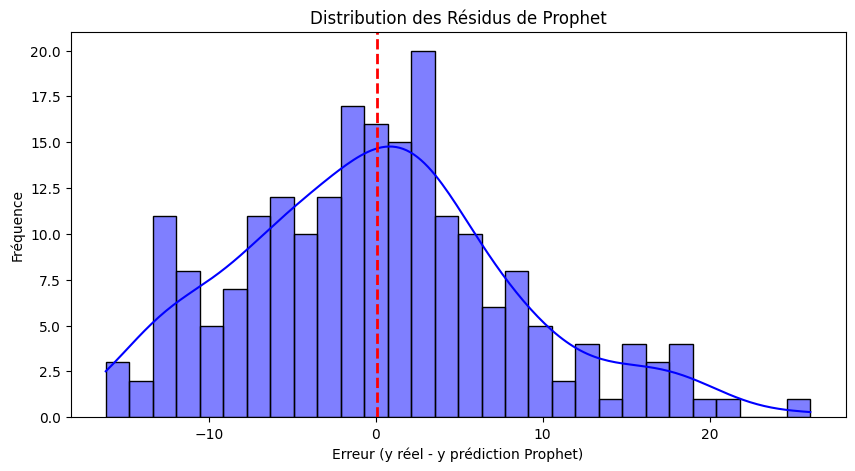

In [89]:
plt.figure(figsize=(10, 5))
sns.histplot(test["residuals"], bins=30, kde=True, color="blue")
plt.axvline(test["residuals"].mean(), color='red', linestyle='dashed', linewidth=2)
plt.title("Distribution des Résidus de Prophet")
plt.xlabel("Erreur (y réel - y prédiction Prophet)")
plt.ylabel("Fréquence")
plt.show()


**📊 Analyse du Graphique des Résidus**

✅ **Les résidus semblent globalement centrés autour de 0** (ce qui est bon signe).  
✅ **Ils suivent une distribution quasi-normale**, mais avec **quelques asymétries et des pics négatifs**.  
❌ **Il y a des valeurs extrêmes (erreurs allant jusqu’à -30 et +20)**, ce qui montre que Prophet **a encore du mal à prédire certains événements exceptionnels**.

**📌 Conclusion**

1️⃣ **Les erreurs Prophet sont plutôt bien réparties**, ce qui signifie que Prophet **capture bien la tendance principale**.  
2️⃣ **Mais il y a des pics d'erreur**, ce qui indique que **certains événements soudains ne sont pas bien prédits** (ex: événements spéciaux, anomalies).  
3️⃣ **Le modèle Machine Learning n'a pas amélioré les prédictions** car **les résidus ne suivent pas un schéma clair** → ils sont **presque aléatoires**.  

📌 **Cela signifie que Prophet est déjà optimal, et qu’ajouter ML n’aide pas vraiment. On retient alors le modèle Prophet avec MAE = 6.16 comme le meilleur modèle**.

## **Meilleur modèle**

In [90]:
df_prophet = train.rename(columns={"Date_admission": "ds", "Nombre_admissions": "y"})

external_features = ['Jour_semaine', 'Mois', 'Saison',
       'Vacances_scolaires', 'Température', 'Evenement_Special_Canicule',
       'Evenement_Special_Pollens allergènes',
       'Evenement_Special_Épidémie de gastro',
       'Evenement_Special_Épidémie de grippe']

for feature in external_features:
    df_prophet[feature] = train[feature]

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    # changepoint_prior_scale=0.01
)

for feature in external_features:
    prophet_model.add_regressor(feature)

prophet_model.fit(df_prophet)

df_test = test.rename(columns={"Date_admission": "ds"})
for feature in external_features:
    df_test[feature] = test[feature]

forecast = prophet_model.predict(df_test)

from sklearn.metrics import mean_absolute_error
mae_prophet_updated = mean_absolute_error(test["Nombre_admissions"], forecast["yhat"])

print(f"✅ Prophet amélioré avec variables externes - MAE = {mae_prophet_updated:.2f}")


✅ Prophet amélioré avec variables externes - MAE = 6.16


In [91]:
df_test["ds"] = pd.to_datetime(df_test["ds"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

df_test = df_test.merge(forecast[["ds", "yhat"]], on="ds", how="left")

print(df_test[["ds", "Nombre_admissions", "yhat"]].head(10))


          ds  Nombre_admissions       yhat
0 2024-04-20                 31  30.642650
1 2024-04-21                 33  30.599733
2 2024-04-22                 41  45.671599
3 2024-04-23                 50  34.640238
4 2024-04-24                 30  27.019854
5 2024-04-25                 38  41.006255
6 2024-04-26                 51  47.013618
7 2024-04-27                 34  30.880876
8 2024-04-28                 32  32.498723
9 2024-04-29                 44  47.676953


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


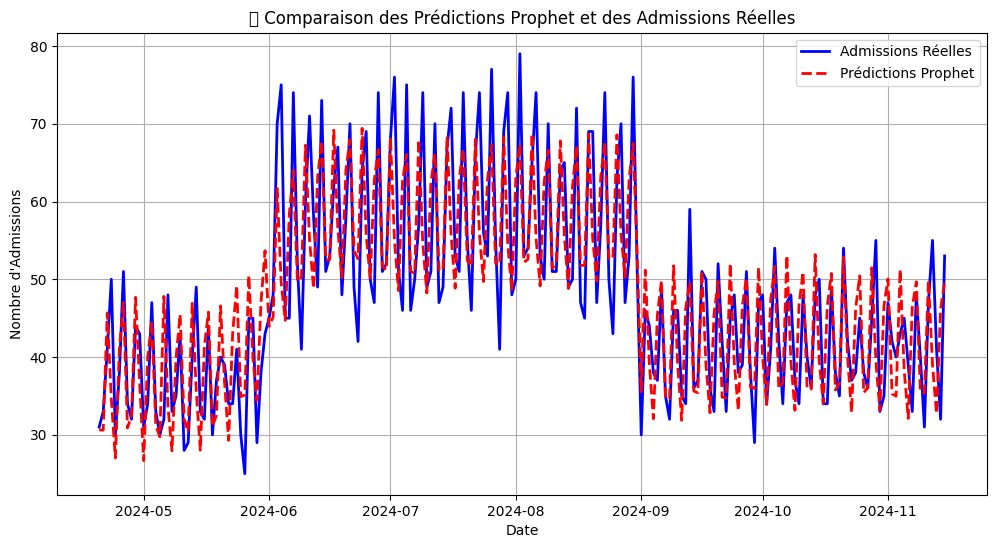

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(df_test["ds"], df_test["Nombre_admissions"], label="Admissions Réelles", color="blue", linewidth=2)
plt.plot(df_test["ds"], df_test["yhat"], label="Prédictions Prophet", color="red", linestyle="dashed", linewidth=2)

plt.title("📊 Comparaison des Prédictions Prophet et des Admissions Réelles")
plt.xlabel("Date")
plt.ylabel("Nombre d'Admissions")
plt.legend()
plt.grid(True)

plt.show()


### **📊 Interprétation du Graphique**
1️⃣ **Alignement global correct** :  
   - Le modèle Prophet suit bien la tendance générale des admissions réelles.  
   - Les pics et les creux sont bien capturés, notamment pendant les périodes de forte variation.

2️⃣ **Reproduction de la saisonnalité** :  
   - On observe une certaine cyclicité dans les admissions, que le modèle arrive à capter.  
   - Les fluctuations journalières sont bien reproduites, même si certains écarts subsistent.

3️⃣ **Quelques écarts ponctuels** :  
   - À certains moments, le modèle **sous-estime ou surestime légèrement** le nombre d’admissions.  
   - Cela peut être dû à des événements spéciaux ou à des variations non totalement capturées par les régressions externes.

4️⃣ **Transitions bien gérées** :  
   - Lors des changements de tendance (ex: autour de juin et septembre 2024), Prophet ajuste bien ses prédictions.

### **📌 Conclusion**
Le modèle Prophet retenu offre une **bonne performance globale** avec une **MAE de 6.16**.🚀

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


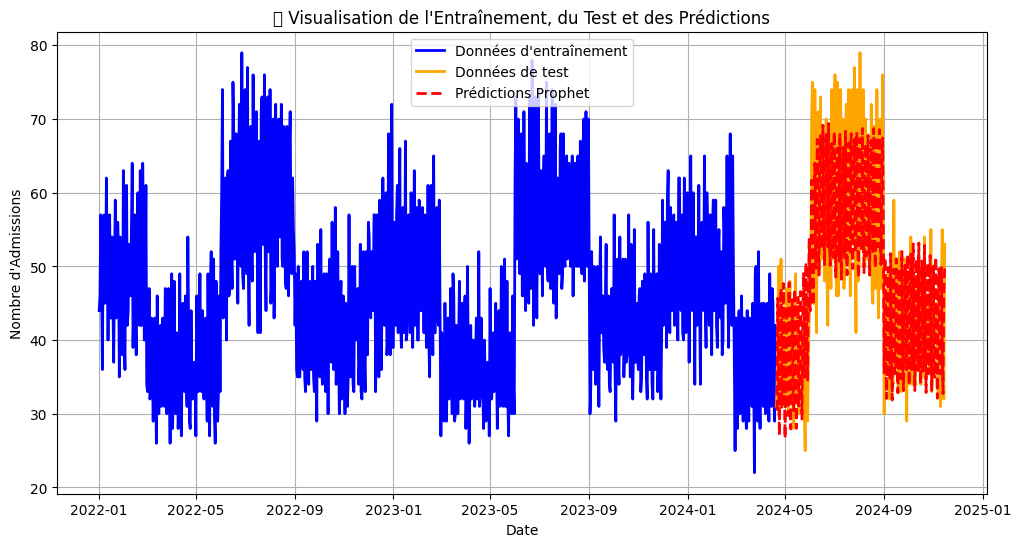

In [93]:
train["ds"] = pd.to_datetime(train["Date_admission"])
test["ds"] = pd.to_datetime(test["Date_admission"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

plt.figure(figsize=(12, 6))

plt.plot(train["ds"], train["Nombre_admissions"], label="Données d'entraînement", color="blue", linewidth=2)

plt.plot(test["ds"], test["Nombre_admissions"], label="Données de test", color="orange", linewidth=2)

plt.plot(forecast["ds"], forecast["yhat"], label="Prédictions Prophet", color="red", linestyle="dashed", linewidth=2)

plt.title("📊 Visualisation de l'Entraînement, du Test et des Prédictions")
plt.xlabel("Date")
plt.ylabel("Nombre d'Admissions")
plt.legend()
plt.grid(True)

plt.show()


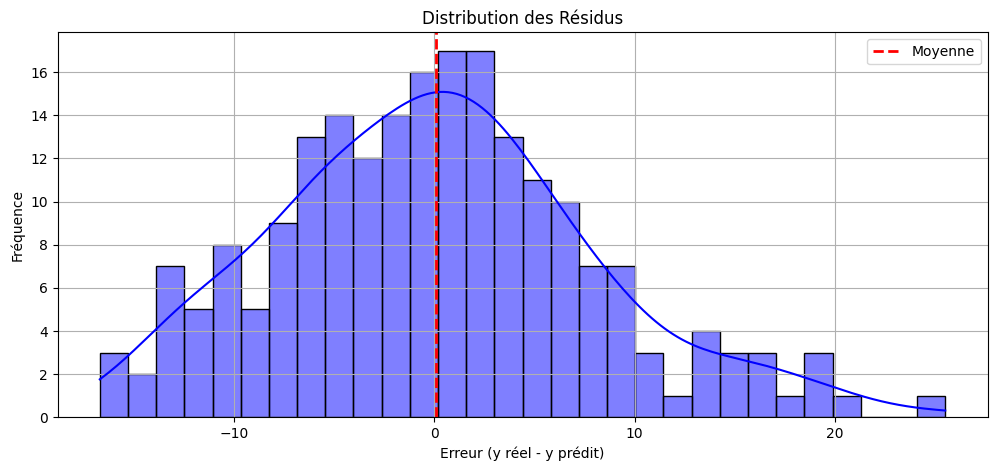

Test de Shapiro-Wilk : p-value = 0.0426 ❌ Non Normale
Test de Jarque-Bera : p-value = 0.0673 Normale


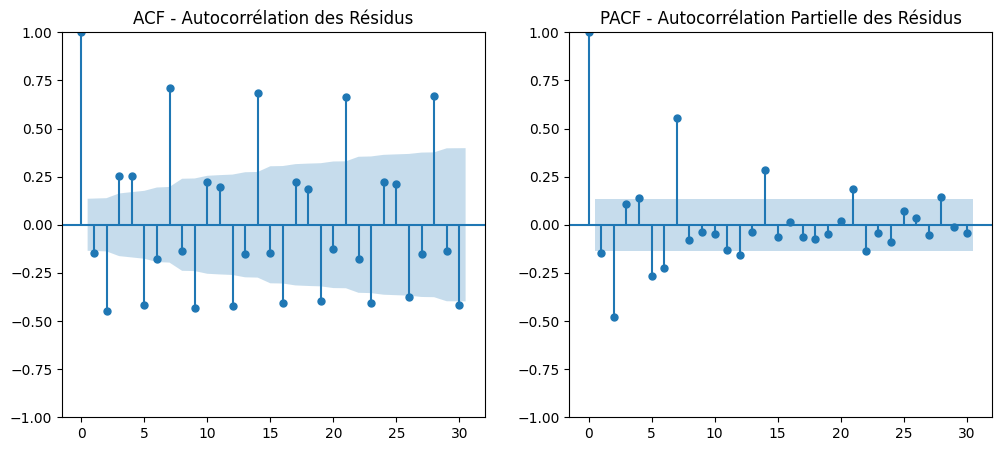

Test de Dickey-Fuller Augmenté (ADF) : p-value = 0.0062 Stationnaire


In [94]:
df_test["résidus"] = df_test["Nombre_admissions"] - df_test["yhat"]

plt.figure(figsize=(12, 5))
sns.histplot(df_test["résidus"], bins=30, kde=True, color="blue")
plt.axvline(df_test["résidus"].mean(), color='red', linestyle='dashed', linewidth=2, label="Moyenne")
plt.title("Distribution des Résidus")
plt.xlabel("Erreur (y réel - y prédit)")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True)
plt.show()

shapiro_test = shapiro(df_test["résidus"].dropna())
jarque_bera_test = jarque_bera(df_test["résidus"].dropna())

print(f"Test de Shapiro-Wilk : p-value = {shapiro_test.pvalue:.4f} {'Normale' if shapiro_test.pvalue > 0.05 else '❌ Non Normale'}")
print(f"Test de Jarque-Bera : p-value = {jarque_bera_test[1]:.4f} {'Normale' if jarque_bera_test[1] > 0.05 else '❌ Non Normale'}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_test["résidus"].dropna(), ax=axes[0], lags=30)
axes[0].set_title("ACF - Autocorrélation des Résidus")
plot_pacf(df_test["résidus"].dropna(), ax=axes[1], lags=30)
axes[1].set_title("PACF - Autocorrélation Partielle des Résidus")
plt.show()

adf_test = adfuller(df_test["résidus"].dropna())
print(f"Test de Dickey-Fuller Augmenté (ADF) : p-value = {adf_test[1]:.4f} {'Stationnaire' if adf_test[1] < 0.05 else '❌ Non Stationnaire'}")


### **📊 Résidus du Modèle Prophet**

#### **1️⃣ Distribution des Résidus**
- La distribution des erreurs **n'est pas totalement symétrique**. On observe une **asymétrie vers les valeurs positives**.
- Cela signifie que **le modèle a tendance à sous-estimer certaines valeurs élevées des admissions**.
- La **moyenne des résidus est proche de zéro**, ce qui est un bon signe, mais la queue droite de la distribution indique des valeurs d'erreur élevées.

📌 **Conclusion** : Le modèle fait globalement de bonnes prédictions, mais sous-estime certaines hausses d’admission.

---

#### **2️⃣ Autocorrélation des Résidus (ACF & PACF)**
- **ACF (Autocorrelation Function)** : Plusieurs pics dépassent l'intervalle de confiance bleu. Cela signifie que les erreurs successives sont **corrélées dans le temps** → Indique que certaines informations temporelles ne sont pas bien capturées par le modèle.
- **PACF (Partial Autocorrelation Function)** : Quelques lags montrent des corrélations significatives, notamment aux premiers décalages temporels. Cela suggère que des tendances sous-jacentes persistent et ne sont pas totalement modélisées.

📌 **Conclusion** : L'**autocorrélation des résidus indique un manque de capture des dépendances temporelles**. Une solution pourrait être d'augmenter la **capacité du modèle à capter les tendances** (ex: ajuster `changepoint_prior_scale`).

---

### **📌 Recommandations pour Améliorer le Modèle**
✅ **1. Augmenter la flexibilité de Prophet**  
- Augmenter `changepoint_prior_scale` pour capter davantage les changements brusques. Ex: `changepoint_prior_scale=0.1` au lieu de `0.05`.

✅ **2. Ajouter des variables explicatives temporelles supplémentaires**  
- Créer une variable "tendance" (ex: rolling mean sur 7 jours) pour aider Prophet à mieux suivre les variations.

✅ **3. Essayer une transformation des données (log, Box-Cox) si nécessaire**  
- Si les erreurs sont trop biaisées, une transformation des données peut parfois aider Prophet à mieux s’adapter.

---

📌 **Globalement, le modèle fonctionne bien, mais pourrait être amélioré pour mieux capter les variations soudaines d’admissions ! 🚀**

### **Sauvegarde modèle et encodeur**

In [95]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/prophet_model.pkl"
joblib.dump(prophet_model, model_path)

print(f"✅ Modèle Prophet sauvegardé dans : {model_path}")


✅ Modèle Prophet sauvegardé dans : /content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/prophet_model.pkl


In [96]:
encoder_ordinal_path = "/content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/ordinal_encoder.pkl"
encoder_onehot_path = "/content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/onehot_encoder.pkl"
scaler_path = "/content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/scaler.pkl"

joblib.dump(ordinal_encoder, encoder_ordinal_path)
joblib.dump(onehot_encoder, encoder_onehot_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Encodage Ordinal sauvegardé dans : {encoder_ordinal_path}")
print(f"✅ Encodage OneHot sauvegardé dans : {encoder_onehot_path}")
print(f"✅ Standardisation sauvegardée dans : {scaler_path}")


✅ Encodage Ordinal sauvegardé dans : /content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/ordinal_encoder.pkl
✅ Encodage OneHot sauvegardé dans : /content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/onehot_encoder.pkl
✅ Standardisation sauvegardée dans : /content/drive/MyDrive/Colab Notebooks/Hopital_projet/models/scaler.pkl


# **Prédiction des Ressources Médicales**

In [97]:
X_train = train.drop(columns=["Date_admission", "Annee", "Jour", 'Lits occupes', "Materiel utilise",
                              "Nb medecin", "Nb infirmier", "Nb aide soignant", "yhat_prophet", "residuals", "ds"])
X_test = test.drop(columns=["Date_admission", "Annee", "Jour", 'Lits occupes', "Materiel utilise",
                            "Nb medecin", "Nb infirmier", "Nb aide soignant", "yhat_prophet", "residuals", "ds", "final_prediction"])

X_train["Vacances_scolaires"] = X_train["Vacances_scolaires"].astype(int)
X_test["Vacances_scolaires"] = X_test["Vacances_scolaires"].astype(int)

target_variables = ["Nb medecin", "Nb infirmier", "Nb aide soignant"]

models = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Régression Linéaire": LinearRegression()
}

param_grids = {
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [10, 20, None]},
    "XGBoost": {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1]},
    "Régression Linéaire": {}  # Pas d'hyperparamètres pour la régression linéaire
}

best_models_per_target = {}
results_per_target = {}

for target in target_variables:
    print(f"\n🔍 **Prédiction de : {target}**")

    y_train = train[target]
    y_test = test[target]

    best_model = None
    best_model_name = None
    best_mae = float("inf")

    for model_name, model in models.items():
        print(f"   🔹 Entraînement du modèle : {model_name}")

        if param_grids[model_name]:  # Vérifier si hyperparamètres à optimiser
            grid_search = GridSearchCV(model, param_grids[model_name], scoring="neg_mean_absolute_error", cv=3, n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
        else:
            model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"   ✅ {model_name} - MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² = {r2:.2f}")

        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_model_name = model_name

    best_models_per_target[target] = best_model
    results_per_target[target] = {"Best Model": best_model_name, "MAE": best_mae}

    print(f"🏆 **Meilleur modèle pour {target} : {best_model_name}** avec MAE = {best_mae:.2f}")

print("\n🎯 **Meilleurs modèles par cible :**")
for target, result in results_per_target.items():
    print(f"   - {target} : {result['Best Model']} avec MAE = {result['MAE']:.2f}")



🔍 **Prédiction de : Nb medecin**
   🔹 Entraînement du modèle : Random Forest
Fitting 3 folds for each of 6 candidates, totalling 18 fits
   ✅ Random Forest - MAE = 1.36, RMSE = 1.69, R² = 0.81
   🔹 Entraînement du modèle : XGBoost
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   ✅ XGBoost - MAE = 1.33, RMSE = 1.64, R² = 0.82
   🔹 Entraînement du modèle : Régression Linéaire
   ✅ Régression Linéaire - MAE = 1.51, RMSE = 1.87, R² = 0.76
🏆 **Meilleur modèle pour Nb medecin : XGBoost** avec MAE = 1.33

🔍 **Prédiction de : Nb infirmier**
   🔹 Entraînement du modèle : Random Forest
Fitting 3 folds for each of 6 candidates, totalling 18 fits
   ✅ Random Forest - MAE = 1.06, RMSE = 1.36, R² = 0.96
   🔹 Entraînement du modèle : XGBoost
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   ✅ XGBoost - MAE = 1.02, RMSE = 1.31, R² = 0.96
   🔹 Entraînement du modèle : Régression Linéaire
   ✅ Régression Linéaire - MAE = 0.97, RMSE = 1.22, R² = 0.97
🏆 **Meilleur modèle pour N

## **Analys résidu et features importance**


🔍 **Entraînement et Analyse du Modèle pour Nb medecin**
📊 Nb medecin - MAE = 1.33, RMSE = 1.64, R² = 0.82


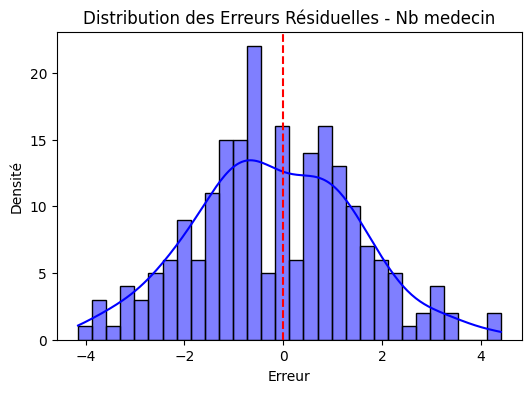

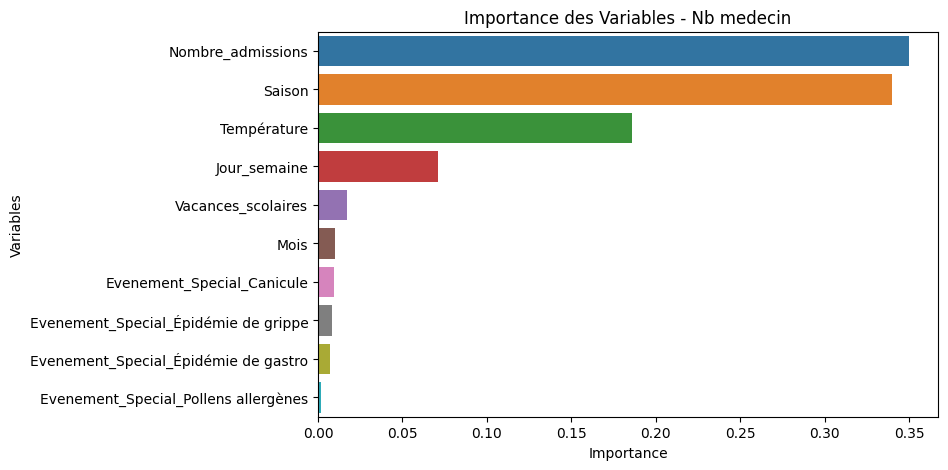


🔍 **Entraînement et Analyse du Modèle pour Nb infirmier**
📊 Nb infirmier - MAE = 0.97, RMSE = 1.22, R² = 0.97


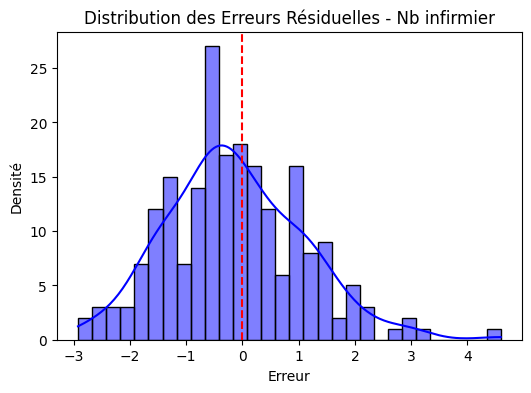


🔍 **Entraînement et Analyse du Modèle pour Nb aide soignant**
📊 Nb aide soignant - MAE = 1.38, RMSE = 1.74, R² = 0.81


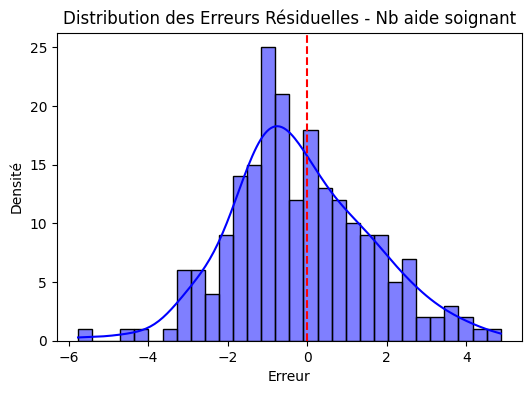

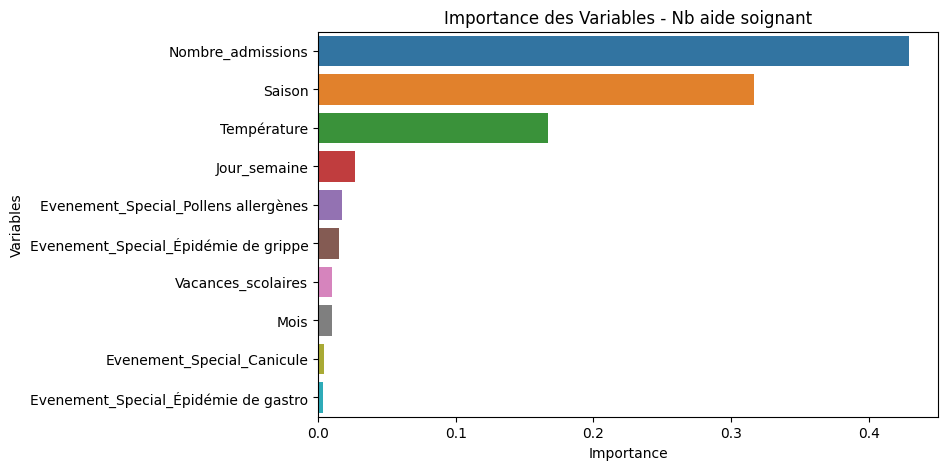

In [98]:
best_models_params = {
    "Nb medecin": XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1),
    "Nb infirmier": LinearRegression(),
    "Nb aide soignant": XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
}

trained_models = {}

for target, model in best_models_params.items():
    print(f"\n🔍 **Entraînement et Analyse du Modèle pour {target}**")

    y_train = train[target]
    y_test = test[target]

    model.fit(X_train, y_train)
    trained_models[target] = model

    y_pred = model.predict(X_test)

    residuals = y_test - y_pred
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"📊 {target} - MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² = {r2:.2f}")

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30, color="blue")
    plt.axvline(0, color="red", linestyle="--")
    plt.title(f"Distribution des Erreurs Résiduelles - {target}")
    plt.xlabel("Erreur")
    plt.ylabel("Densité")
    plt.show()

    if target in ["Nb medecin", "Nb aide soignant"]:  # XGBoost a une importance des variables
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=feature_importances[sorted_idx],
                    y=np.array(X_train.columns)[sorted_idx],  # Correction pour éviter une erreur d'indexation
                    hue=np.array(X_train.columns)[sorted_idx],  # Assigner la variable Y à `hue`
                    dodge=False,  # Désactive la séparation des catégories
                    legend=False  # Désactive la légende inutile
        )
        plt.title(f"Importance des Variables - {target}")
        plt.xlabel("Importance")
        plt.ylabel("Variables")
        plt.show()



L'analyse des erreurs résiduelles et de l'importance des variables pour les modèles de prédiction du nombre de médecins, infirmiers et aides-soignants montre plusieurs points clés :

1. **Distribution des erreurs résiduelles :**
   - Les erreurs semblent suivre une distribution normale pour les trois modèles, avec une moyenne proche de zéro, ce qui est un bon indicateur de la qualité du modèle.
   - Cependant, il y a quelques valeurs extrêmes (queue de distribution allongée), suggérant qu'il existe des cas où le modèle sous-estime ou surestime les effectifs nécessaires.

2. **Importance des variables :**
   - **Nb Médecins :** La saison, le nombre d'admissions et la température sont les facteurs les plus influents.
   - **Nb Infirmiers :** Le modèle basé sur la régression linéaire n'a pas d'importance de variables affichable directement comme un modèle basé sur des arbres.
   - **Nb Aides-soignants :** Le nombre d'admissions est le facteur le plus influent, suivi de la saison et de la température.

## **Sauvegarde des modèles**

In [99]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/Hopital_projet/models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(trained_models["Nb medecin"], os.path.join(model_dir, "model_nb_medecins.pkl"))
joblib.dump(trained_models["Nb infirmier"], os.path.join(model_dir, "model_nb_infirmiers.pkl"))
joblib.dump(trained_models["Nb aide soignant"], os.path.join(model_dir, "model_nb_aides_soignants.pkl"))

print("✅ Modèles et transformations sauvegardés avec succès dans :", model_dir)


✅ Modèles et transformations sauvegardés avec succès dans : /content/drive/MyDrive/Colab Notebooks/Hopital_projet/models
